# Open new Turkish Restaurant in Bucharest, Romania


In [1]:
pip install geocoder


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install et_xmlfile

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.


In [4]:
#import libraries 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt # for graphical usage 

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

# main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/
# how to use the BeautifulSoup package: https://www.youtube.com/watch?v=ng2o98k983k video
from bs4 import BeautifulSoup 
import pandas as pd
import requests

print('Libraries imported.')

Libraries imported.


In [5]:
# get coordinates of Bucharest
bucharest_address = 'Bucharest, Romania'

geolocator = Nominatim(user_agent="bucharest_explorer")
location = geolocator.geocode(bucharest_address)
latitude = location.latitude
longitude = location.longitude
bucharest_center = [latitude, longitude ]
print('The geograpical coordinate of {} are {}, {}.'.format(bucharest_address, latitude, longitude))

The geograpical coordinate of Bucharest, Romania are 44.4361414, 26.1027202.


In [6]:
url = "https://en.wikipedia.org/wiki/Category:Districts of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

neighborhoodList = []

# append the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text.replace(', Bucharest',''))
    
df_neighborhood = pd.DataFrame({"Neighborhood": neighborhoodList})
print("There are {} neighborhoods in {}".format(df_neighborhood.shape[0], bucharest_address))

There are 40 neighborhoods in Bucharest, Romania


In [7]:
# Read Bucharest sector data from wikipedia
url = "https://en.wikipedia.org/wiki/Sectors of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

sectorPopList = []
sectorPopulationList = []

for row in soup.find_all("tbody"):
    header = str(row.findAll("th"))
    if "Population (October 2011)" in header:
        i = 0
        for td in row.find_all("td"):
            i+=1
            if i==2: 
                sectorPopList.append(td.text.replace("\n",""))
            if i==3: 
                sectorPopulationList.append(td.text.replace("\n",""))    
                i=0

df_sectorPop = pd.DataFrame({"Sector": sectorPopList, "Population": sectorPopulationList})

sectorNeigList =[]
sectorNeigborList =[]

for row in soup.find_all("ul"):
    if sectorPopList[0] in  row.text:
        for s in row.text.split("\n"):
            sectorNeigList.append(s.split(":")[0])
            sectorNeigborList.append(s.split(":")[1])
    
df_sector= pd.DataFrame({"Sector": sectorNeigList, "Neigborhoods": sectorNeigborList}).merge(df_sectorPop,on='Sector' )

print("There are {} Sector in {}".format(df_sector.shape[0], bucharest_address))
df_sector

There are 6 Sector in Bucharest, Romania


,Sector,Neigborhoods,Population
0,Sector 1,"Dorobanți, Băneasa, Aviației, Pipera, Aviator...","225,454"
1,Sector 2,"Pantelimon, Colentina, Iancului, Tei, Floreas...","345,370"
2,Sector 3,"Vitan, Dudești, Titan, Centrul Civic, Balta A...","385,439"
3,Sector 4,"Berceni, Olteniței, Văcărești, Timpuri Noi, T...","287,828"
4,Sector 5,"Rahova, Ferentari, Giurgiului, Cotroceni, 13 ...","271,575"
5,Sector 6,"Giulești, Crângași, Drumul Taberei, Militari,...","367,760"


In [8]:
def getSector(row):
    for i in range(df_sector.shape[0]):
        if row["Neighborhood"] in  df_sector.iloc[i].Neigborhoods:
            return pd.Series([df_sector.iloc[i].Sector, df_sector.iloc[i].Population], index = ['Sector','SectorPopulation'])

df_neighborhood[["Sector","SectorPopulation"]] =df_neighborhood.apply(getSector, axis=1)
df_neighborhood.head(5)

,Neighborhood,Sector,SectorPopulation
0,Aviației,Sector 1,"225,454"
1,Băneasa,Sector 1,"225,454"
2,Berceni,Sector 4,"287,828"
3,Bucureștii Noi,Sector 1,"225,454"
4,Centrul Civic,Sector 3,"385,439"


In [9]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood,bucharest_address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighborhood) for neighborhood in df_neighborhood["Neighborhood"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
df_neighborhood['Latitude'] = df_coords['Latitude']
df_neighborhood['Longitude'] = df_coords['Longitude']
print("Geographical coordinates of five neighborhoods are as below")
df_neighborhood.head()

Geographical coordinates of five neighborhoods are as below


,Neighborhood,Sector,SectorPopulation,Latitude,Longitude
0,Aviației,Sector 1,"225,454",44.485790,26.101219
1,Băneasa,Sector 1,"225,454",44.494012,26.080358
2,Berceni,Sector 4,"287,828",44.386430,26.128490
3,Bucureștii Noi,Sector 1,"225,454",44.480413,26.042807
4,Centrul Civic,Sector 3,"385,439",44.434300,26.094660


In [10]:
map_bucharest= folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng,  neighborhood in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bucharest)  
    
map_bucharest

In [11]:
CLIENT_ID = '5PUZADNNWEHF2X4QZQNFHUBBGGETMHNYAA5UOMALUJP0TS01' # your Foursquare ID
CLIENT_SECRET = 'ITIGXCFBI1AQ1VIRN4QSU1GR4L3SJZYI12LPSDAWUUMEVG3F' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5PUZADNNWEHF2X4QZQNFHUBBGGETMHNYAA5UOMALUJP0TS01
CLIENT_SECRET:ITIGXCFBI1AQ1VIRN4QSU1GR4L3SJZYI12LPSDAWUUMEVG3F


In [12]:


def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=1000 ):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]["items"]

        # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighborhood_venues = getNeighborhoodVenues (df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

There are 178 unique venue categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,Aviației,44.48579,26.101219,LIDL,583956246d349d0574eb02ac,44.488396,26.094375,616,Supermarket
1,Aviației,44.48579,26.101219,ibis Styles Bucharest Erbas,5bbb782175dcb7002cc15ee7,44.483963,26.097134,382,Hotel
2,Aviației,44.48579,26.101219,Mega Image Concept Store,56348b62498e53f51a0a4e0e,44.479783,26.102568,677,Supermarket
3,Aviației,44.48579,26.101219,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,716,Burger Joint
4,Aviației,44.48579,26.101219,Starbucks,525fd077498eed1c5a52c1d6,44.478522,26.102503,815,Coffee Shop


In [13]:
print('Top 10 distinct venue counts are as below')
neighborhood_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:10]


Top 10 distinct venue counts are as below


,Count
VenueCategory,
Coffee Shop,40
Italian Restaurant,31
Café,31
Restaurant,31
Gym,28
Gym / Fitness Center,26
Supermarket,25
Pizza Place,25
Park,22


In [14]:

restaurant_list =['Restaurant', 'Burger Joint','Café','Fried Chicken Joint','Pizza Place']
turkish_restaurant_list = ['Turkish Restaurant', 'Doner Restaurant']

# Filter restaurants 
    
neighborhood_venues['RestFlag']=False
for restCat in restaurant_list:
    neighborhood_venues['RestFlag'] = neighborhood_venues['RestFlag'] | neighborhood_venues['VenueCategory'].str.contains(restCat)
    
neighborhood_restaurants = neighborhood_venues[neighborhood_venues['RestFlag'] == True].iloc[:,:-1]
turkish_restaurants = neighborhood_restaurants[ neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]
other_restaurants = neighborhood_restaurants[ ~neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]

print('Total number of restaurants:', len(neighborhood_restaurants['VenueId'].unique()))
print('Total number of Turkish restaurants:', len(turkish_restaurants['VenueId'].unique()))
print('Percentage of Turkish restaurants: {:.2f}%'.format(len(turkish_restaurants['VenueId'].unique()) / len(neighborhood_restaurants['VenueId'].unique()) * 100))

Total number of restaurants: 250
Total number of Turkish restaurants: 17
Percentage of Turkish restaurants: 6.80%


25 neighborhoods do not have any Turkish restaurant


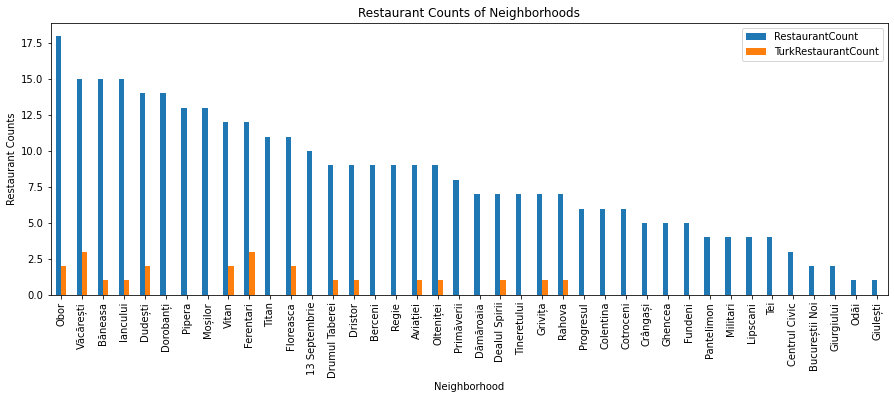

In [15]:
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(neighborhood_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'RestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)

#####
# get counts of Turkish restaurants in each Neighborhood
df_turk_rest_counts =  turkish_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "TurkRestaurantCount"})[['TurkRestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(turkish_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_turk_rest_counts = df_turk_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'TurkRestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_turk_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_turk_rest_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)

print('{} neighborhoods do not have any Turkish restaurant'.format(len(noRestList)))
######
#Draw graph
df_rest_counts[['RestaurantCount','TurkRestaurantCount']].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()

In [16]:
def getVenueRaitings(venues):
    
    raitings = []
    likes =[]
    for venueId in venues:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            rating = result['response']['venue']['rating']
            likes = result['response']['venue']['likes']['count']
        except:
            rating = None
            likes = None
        
        raitings.append((venueId, rating,likes))
 
    # convert the venues list into a DataFrame
    rating = pd.DataFrame(raitings)
    # define the column names
    rating.columns = ['VenueId', 'VenueRating','VenueLikes']

    return rating    

restaurants_raitings = getVenueRaitings(neighborhood_restaurants['VenueId'].drop_duplicates())
restaurants_raitings.head()

,VenueId,VenueRating,VenueLikes
0,58a2fc95d0bb3e516a2363b7,None,None
1,55b8a459498efbbb6ca3526d,None,None
2,58bbf8764f1069627380fed5,None,None
3,53623e44498ed583ede334f5,None,None
4,55859bef498eca16beae6deb,None,None


In [17]:
#merge raitings to restaurants 
neighborhood_restaurants = neighborhood_restaurants.merge(restaurants_raitings)
neighborhood_restaurants.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.485790,26.101219,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,716,Burger Joint,None,None
1,Floreasca,44.476308,26.103289,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,351,Burger Joint,None,None
2,Aviației,44.485790,26.101219,Toàn's,55b8a459498efbbb6ca3526d,44.478370,26.103411,844,Vietnamese Restaurant,None,None
3,Floreasca,44.476308,26.103289,Toàn's,55b8a459498efbbb6ca3526d,44.478370,26.103411,229,Vietnamese Restaurant,None,None
4,Aviației,44.485790,26.101219,Manufaktura by Doncafé,58bbf8764f1069627380fed5,44.478429,26.104004,848,Café,None,None


In [18]:

#merge raitings to turkish restaurants 
turkish_restaurants = turkish_restaurants.merge(restaurants_raitings)
turkish_restaurants.head(5)

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.485790,26.101219,Istanbul Taksim,55acc94f498e0a64af6b19af,44.47856,26.103505,825,Turkish Restaurant,None,None
1,Floreasca,44.476308,26.103289,Istanbul Taksim,55acc94f498e0a64af6b19af,44.47856,26.103505,251,Turkish Restaurant,None,None
2,Băneasa,44.494012,26.080358,Shaormeria Băneasa,5137a298e4b0523475c45b54,44.49446,26.080462,50,Doner Restaurant,None,None
3,Dealul Spirii,44.422982,26.069593,Mesopotamia,5415dbc3498efe97bd5e2f89,44.41789,26.072145,602,Doner Restaurant,None,None
4,Ferentari,44.412870,26.073428,Mesopotamia,5415dbc3498efe97bd5e2f89,44.41789,26.072145,568,Doner Restaurant,None,None


In [19]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)
df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig, name in zip(turkish_restaurants['VenueLatitude'], turkish_restaurants['VenueLongitude'], turkish_restaurants['Neighborhood'], turkish_restaurants['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
       
raiting_lt_7 = turkish_restaurants[turkish_restaurants['VenueRating'] <7]
for lat, lon, neig, name in zip(raiting_lt_7['VenueLatitude'], raiting_lt_7['VenueLongitude'], raiting_lt_7['Neighborhood'], raiting_lt_7['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)        
map_restaurant

In [20]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)

df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig in zip(df_neighborhood_noturkrest['Latitude'], df_neighborhood_noturkrest['Longitude'], df_neighborhood_noturkrest['Neighborhood']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_restaurant)
map_restaurant

In [21]:
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# move neighborhood column to the first column and filter only restaurant columns 
fixed_columns =['Neighborhood'] + list(neighborhood_venues['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]

print("{}  neighborhoods' venue category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

40  neighborhoods' venue category are shown in 178 columns as below


,Neighborhood,Supermarket,Hotel,Burger Joint,Coffee Shop,Dessert Shop,Roof Deck,Grocery Store,Vietnamese Restaurant,Beer Garden,Gym / Fitness Center,Salad Place,Salon / Barbershop,Pie Shop,Bookstore,Café,Shopping Mall,Restaurant,Steakhouse,Italian Restaurant,Sushi Restaurant,Clothing Store,Turkish Restaurant,Toy / Game Store,Pizza Place,Romanian Restaurant,Doner Restaurant,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant,Lake,Park,Nightclub,Sandwich Place,Tunnel,Theme Restaurant,Farmers Market,Bed & Breakfast,Food & Drink Shop,Nature Preserve,Gym,Fast Food Restaurant,Lebanese Restaurant,Eastern European Restaurant,Electronics Store,Bakery,Fountain,Metro Station,Cosmetics Shop,Gas Station,Athletics & Sports,Spa,Gym Pool,Pharmacy,Shop & Service,Gastropub,Bistro,Cocktail Bar,Outdoor Sculpture,Indie Theater,Theater,Monastery,Skating Rink,Hardware Store,Fried Chicken Joint,Discount Store,Antique Shop,Arts & Crafts Store,Auto Dealership,Mobile Phone Shop,Herbs & Spices Store,Bus Station,Furniture / Home Store,Gift Shop,Tennis Court,Tea Room,Jazz Club,Accessories Store,Market,Bar,Opera House,Wine Bar,Casino,Pedestrian Plaza,Hotel Bar,Indian Restaurant,Garden,Music Store,Pool,Pub,French Restaurant,Department Store,Cupcake Shop,Climbing Gym,Plaza,Soccer Stadium,Miscellaneous Shop,Lounge,Convenience Store,Japanese Restaurant,Fish Market,Scandinavian Restaurant,Juice Bar,Asian Restaurant,Cheese Shop,Mediterranean Restaurant,Ice Cream Shop,Drugstore,Auto Workshop,Pet Store,Multiplex,Eye Doctor,Chinese Restaurant,Skate Park,Water Park,Wine Shop,Health & Beauty Service,Health Food Store,Camera Store,Seafood Restaurant,Outlet Mall,Platform,Light Rail Station,Portuguese Restaurant,Cable Car,Sports Club,Tram Station,Boxing Gym,Soccer Field,Museum,Spanish Restaurant,History Museum,Concert Hall,Food Truck,Kebab Restaurant,Exhibit,Greek Restaurant,Used Bookstore,Chocolate Shop,Tattoo Parlor,Sporting Goods Shop,Rock Club,Historic Site,Swiss Restaurant,Beer Bar,Art Gallery,Gourmet Shop,Falafel Restaurant,Palace,BBQ Joint,Modern European Restaurant,Beach,Auto Garage,Shoe Store,Diner,Food,Bagel Shop,Go Kart Track,Snack Place,Event Space,Indoor Play Area,IT Services,Souvlaki Shop,Track,Stadium,Basketball Court,Recreation Center,Paper / Office Supplies Store,Bowling Alley,German Restaurant,Pool Hall,Baby Store,Buffet,Comfort Food Restaurant,American Restaurant,ATM,Hookah Bar,Soup Place,Women's Store,Boutique
0,13 Septembrie,0,1,0,0,0,0,0,0,0,2,0,0,0,0,2,0,2,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,1,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,Aviației,3,2,1,1,2,1,1,1,1,2,1,1,1,1,2,1,2,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Berceni,0,0,0,1,0,0,3,0,1,2,0,0,0,0,0,0,0,0,1,0,0,0,0,4,1,0,0,0,0,1,0,0,0,0,2,0,1,1,2,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bucureștii Noi,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Băneasa,1,2,0,1,0,0,1,0,0,1,0,0,0,0,3,0,3,0,2,0,0,0,0,1,2,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0

In [23]:
# create a new dataframe with most common venue catrgories
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['Neighborhood','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
venues_most = pd.DataFrame(columns = columns)

for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Neighborhood'] = venues_grouped.iloc[ind].Neighborhood
    venues_most.loc[ind, 'Total Number of Venues'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most.head()

,Neighborhood,Total Number of Venues,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,13 Septembrie,30,Tea Room,Gym / Fitness Center,Restaurant,Café,Jazz Club,Park,Palace,Chocolate Shop,Romanian Restaurant,Cocktail Bar
1,Aviației,30,Supermarket,Hotel,Dessert Shop,Restaurant,Gym / Fitness Center,Café,Bookstore,Toy / Game Store,Turkish Restaurant,Clothing Store
2,Berceni,28,Pizza Place,Grocery Store,Farmers Market,Gym,Gym / Fitness Center,Bakery,Eastern European Restaurant,Romanian Restaurant,Food & Drink Shop,Nature Preserve
3,Bucureștii Noi,17,Grocery Store,Farmers Market,Park,Supermarket,Restaurant,Metro Station,Spa,Gym Pool,Pharmacy,Shop & Service
4,Băneasa,29,Restaurant,Café,Hotel,Romanian Restaurant,Italian Restaurant,Park,Pizza Place,Doner Restaurant,Vegetarian / Vegan Restaurant,Lake


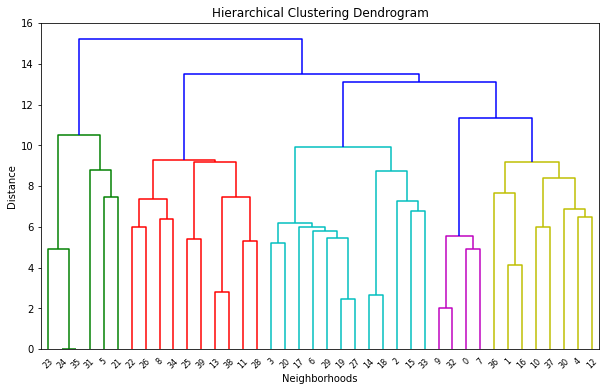

In [24]:
import scipy.cluster.hierarchy as shc

data = venues_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=20, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

In [25]:
from sklearn.cluster import AgglomerativeClustering

kclusters= 6
cluster = AgglomerativeClustering(n_clusters=kclusters, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)

venues_grouped['NeighborhoodCluster'] = clusterresult
venues_cluster= df_neighborhood.merge(venues_grouped[['Neighborhood','NeighborhoodCluster']])
venues_cluster =venues_cluster.merge(venues_most[['Neighborhood','1st Most Common Restaurant','2nd Most Common Restaurant','3rd Most Common Restaurant']])
venues_cluster.head()

,Neighborhood,Sector,SectorPopulation,Latitude,Longitude,NeighborhoodCluster,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant
0,Aviației,Sector 1,"225,454",44.485790,26.101219,1,Supermarket,Hotel,Dessert Shop
1,Băneasa,Sector 1,"225,454",44.494012,26.080358,1,Restaurant,Café,Hotel
2,Berceni,Sector 4,"287,828",44.386430,26.128490,0,Pizza Place,Grocery Store,Farmers Market
3,Bucureștii Noi,Sector 1,"225,454",44.480413,26.042807,0,Grocery Store,Farmers Market,Park
4,Centrul Civic,Sector 3,"385,439",44.434300,26.094660,3,Coffee Shop,Hotel,Bakery


In [27]:
#create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster, sector,SectorPopulation  in zip(venues_cluster['Latitude'], venues_cluster['Longitude'], venues_cluster['Neighborhood'], venues_cluster['NeighborhoodCluster'], venues_cluster['Sector'],venues_cluster['SectorPopulation']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster)+ ' ' + str(sector) + ' ' + str(SectorPopulation), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
folium.Marker(bucharest_center).add_to(map_clusters)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_clusters)         
map_clusters

In [28]:
print(venues_cluster.groupby(['NeighborhoodCluster','1st Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"}))

venues_cluster.groupby(['NeighborhoodCluster','2nd Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"})

                                                Neighborhood Count
NeighborhoodCluster 1st Most Common Restaurant                    
0                   Burger Joint                                 1
                    Grocery Store                                2
                    Park                                         1
                    Pharmacy                                     1
                    Pizza Place                                  1
                    Pool                                         1
                    Romanian Restaurant                          1
                    Soccer Field                                 1
                    Supermarket                                  3
1                   Café                                         2
                    Clothing Store                               1
                    Coffee Shop                                  2
                    Ice Cream Shop                            

Neighborhood Count
NeighborhoodCluster 2nd Most Common Restaurant                    
0                   Auto Garage                                  1
                    Bar                                          1
                    Bus Station                                  2
                    Doner Restaurant                             1
                    Farmers Market                               1
                    Grocery Store                                1
                    Gym / Fitness Center                         1
                    Museum                                       1
                    Pizza Place                                  1
                    Restaurant                                   1
                    Salon / Barbershop                           1
1                   Café                                         1
                    Coffee Shop                                  1
                    Hotel                                        1
                    Middle Eastern Restaurant                    1
                    Restaurant                                   2
                    Shoe Store                                   1
                    Wine Bar                                     1
2                   Café                                         1
                    Coffee Shop                                  1
                    Gym / Fitness Center                         2
                    Italian Restaurant                           1
                    Lounge                                       2
                    Pizza Place                                  1
                    Pub                                          1
                    Supermarket                                  1
3                   Coffee Shop                                  1
                    Dessert Shop                                 1
                    Hotel                                        1
4                   Gym / Fitness Center                         1
                    Italian Restaurant                           1
                    Romanian Restaurant                          2
5                   Coffee Shop                                  2
                    Ice Cream Shop                               1